In [4]:
import pandas as pd

market_df = pd.read_csv("market_log.csv")
tweets_df = pd.read_csv("tweets_log.csv")

print(market_df.head())
print(tweets_df.head())

                    timestamp           id          price     market_cap  \
0  2025-11-07T20:34:05.673377      bitcoin  102853.000000  2050436915703   
1  2025-11-07T20:34:05.673377     ethereum    3430.240000   413444126277   
2  2025-11-07T20:34:05.673377       tether       0.999444   183343964542   
3  2025-11-07T20:34:05.673377       ripple       2.340000   140475360665   
4  2025-11-07T20:34:05.673377  binancecoin     979.940000   134963162765   

         volume  24h_change  
0   92040631231     1.11511  
1   39265435180     2.77786  
2  133528754082    -0.03096  
3    5597424009     5.50698  
4    2552276270     3.35411  
                    timestamp crypto_name tweet_created_at  \
0  2025-11-07T20:35:14.461187    dogecoin               7s   
1  2025-11-07T20:35:14.461187    dogecoin               8s   
2  2025-11-07T20:35:14.461187    dogecoin              35s   
3  2025-11-07T20:35:14.461187    dogecoin               1m   
4  2025-11-07T20:35:14.461187    dogecoin            

In [5]:
from datetime import datetime

# Convert timestamp to datetime
tweets_df["timestamp"] = pd.to_datetime(tweets_df["timestamp"])

# Encode sentiment
tweets_df["sentiment_score"] = tweets_df["sentiment"].map({"positive": 1, "neutral": 0, "negative": -1})

# Aggregate sentiment by crypto (e.g., mean sentiment per crypto per hour)
tweets_agg = (
    tweets_df.groupby("crypto_name")
    .agg(
        avg_sentiment=("sentiment_score", "mean"),
        tweet_volume=("text", "count"),
        avg_likes=("like_count", lambda x: pd.to_numeric(x, errors="coerce").mean()),
        avg_retweets=("retweet_count", lambda x: pd.to_numeric(x, errors="coerce").mean())
    )
    .reset_index()
)
print(tweets_agg.head())


    crypto_name  avg_sentiment  tweet_volume  avg_likes  avg_retweets
0   binancecoin            0.4            10        NaN           NaN
1      dogecoin            0.6            10  47.500000     54.000000
2        ripple            0.3            10  69.833333    101.571429
3        solana            0.4            10  53.200000     40.000000
4  staked-ether            0.6            10  42.250000     87.000000


In [6]:
# Example: merge using crypto name/id
merged_df = market_df.merge(tweets_agg, left_on="id", right_on="crypto_name", how="inner")

# Drop duplicates
merged_df.drop(columns=["crypto_name"], inplace=True)

print(merged_df.head())


                    timestamp           id       price    market_cap  \
0  2025-11-07T20:34:05.673377       tether    0.999444  183343964542   
1  2025-11-07T20:34:05.673377       ripple    2.340000  140475360665   
2  2025-11-07T20:34:05.673377  binancecoin  979.940000  134963162765   
3  2025-11-07T20:34:05.673377       solana  162.940000   90171552230   
4  2025-11-07T20:34:05.673377     usd-coin    0.999704   75468156917   

         volume  24h_change  avg_sentiment  tweet_volume  avg_likes  \
0  133528754082    -0.03096            0.4            10  54.833333   
1    5597424009     5.50698            0.3            10  69.833333   
2    2552276270     3.35411            0.4            10        NaN   
3    6392896979     3.72779            0.4            10  53.200000   
4   12096194657    -0.00946            0.0            10   1.000000   

   avg_retweets  
0     92.333333  
1    101.571429  
2           NaN  
3     40.000000  
4      2.000000  


In [8]:
merged_df["future_change"] = merged_df["24h_change"].shift(-1)  # next record’s % change
merged_df["target"] = (merged_df["future_change"] > 0).astype(int)  # 1 = up, 0 = down

In [9]:
features = ["price", "market_cap", "volume", "avg_sentiment", "tweet_volume", "avg_likes", "avg_retweets"]
X = merged_df[features]
y = merged_df["target"]

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



c:\Users\skouz\OneDrive\Documents\Projects\Crypto-Twits\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\skouz\OneDrive\Documents\Projects\Crypto-Twits\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\skouz\OneDrive\Documents\Projects\Crypto-Twits\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

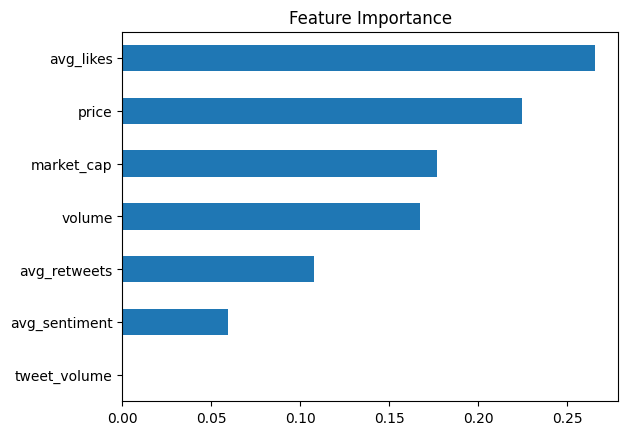

In [13]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", title="Feature Importance")
plt.show()
